In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from scipy.stats import loguniform
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

### Read Dataset

In [ ]:
# Read the Data Set
path = 'df_faults_even.xlsx'

DF_faulty = pd.read_excel(path, index_col=0)
df_filtered = DF_faulty

In [3]:
# Prepare the data
X = df_filtered.drop(columns=['Datetime', 'Fault'])
y = df_filtered['Fault']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


### SFS

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline
import time

lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lgbm_model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# SFS
sfs = SFS(
pipeline,
k_features='best',
forward=True,
floating=False,
cv=cv,
scoring='f1_macro',
n_jobs=-1,
verbose=2
)

# Fit SFS and Time
start_time = time.time()
sfs = sfs.fit(X_train.values, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nSFS completed in {elapsed_time:.2f} seconds")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:  8.5min finished

[2025-04-22 04:56:01] Features: 1/113 -- score: 0.28200979363653367[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 10.8min finished

[2025-04-22 05:06:53] Features: 2/113 -- score: 0.3961563640010898[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed: 11.0min finished

[2025-04-22 05:17:54] Features: 3/113 -- score: 0.5055692774681076[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 110 o


SFS completed in 81978.42 seconds



[2025-04-23 03:33:51] Features: 113/113 -- score: 0.7938452881693814


Best feature subset indices:
(0, 3, 7, 13, 17, 18, 19, 20, 21, 24, 27, 28, 30, 31, 35, 38, 42, 43, 44, 46, 49, 50, 51, 52, 54, 56, 57, 59, 61, 63, 65, 66, 67, 69, 75, 78, 79, 80, 83, 86, 87, 88, 92, 99, 103, 105, 106, 108, 111)

Best feature subset names:
['CDWL_CW_FLOW', 'CDWL_PM_POW_3', 'CHL_COMP_SPD_CTRL_2', 'CHL_RWCD_TEMP_2', 'CHL_RW_TEMP_3', 'CHL_STA_1', 'CHL_STA_2', 'CHL_STA_3', 'CHL_SWCD_TEMP_1', 'CHL_SW_TEMP_1', 'CT_FAN_SPD_1', 'CT_FAN_SPD_2', 'CT_FAN_SPD_CTRL_1', 'CT_FAN_SPD_CTRL_2', 'CT_FLOW_3', 'CT_POW_3', 'CT_STA_1', 'CT_STA_2', 'CT_STA_3', 'CT_SW_TEMP_1', 'CWL_PRI_CW_FLOW', 'CWL_PRI_PM_POW_1', 'CWL_PRI_PM_POW_2', 'CWL_PRI_PM_POW_3', 'CWL_PRI_SW_TEMP', 'CWL_SEC_CW_FLOW', 'CWL_SEC_DP', 'CWL_SEC_PM_POW_1', 'CWL_SEC_PM_SPD_1', 'CWL_SEC_PM_STA_1', 'CWL_SEC_RW_TEMP', 'CWL_SEC_SW_TEMP', 'OA_TEMP_WB', 'TWV_CTRL', 'CHL_Cooling_Load_2', 'CHL_DeltaTEMP_3', 'CHL_Cooling_Load_3', 'CHL_COP_3', 'CHL_CD_TotalFLOW', 'CT_Eff_1', 'CT_ApproachTEMP_1', 'CT_Error_1', 'CT_Eff_2', 'CT_ApproachTE

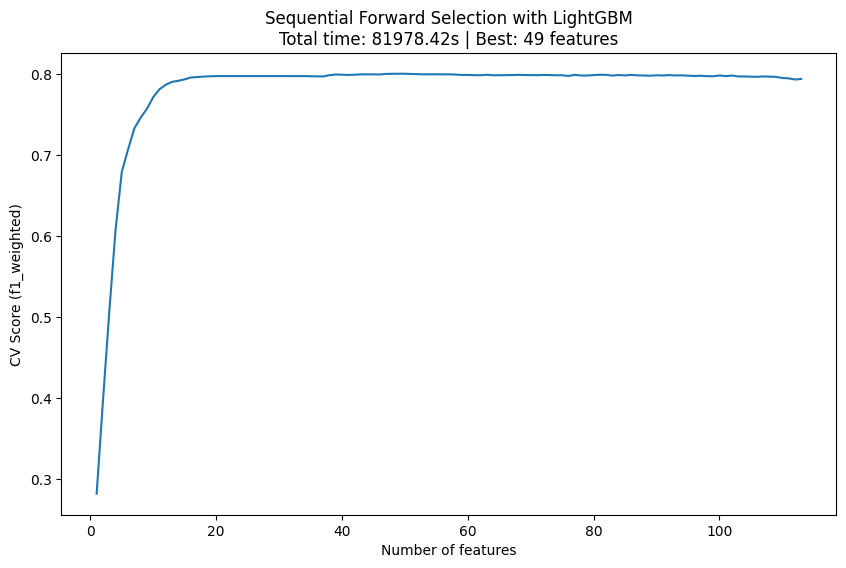

In [ ]:
# Maximum F1 score
selected_feature_indices = sfs.k_feature_idx_
selected_feature_names = [X_train.columns[i] for i in selected_feature_indices]
best_f1_score = sfs.subsets_[len(selected_feature_indices)]['avg_score']
#print("\nBest feature subset indices:")
#print(selected_feature_indices)
print("\nBest feature subset names:")
print(selected_feature_names)
print(f"\nBest F1-Score: {best_f1_score:.4f}")

# Plot Graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sfs.subsets_)+1), 
         [sfs.subsets_[k]['avg_score'] for k in range(1, len(sfs.subsets_)+1)])
plt.xlabel('Number of features')
plt.ylabel('CV Score (f1_weighted)')
plt.title('Sequential Forward Selection with LightGBM\n'
          f'Total time: {elapsed_time:.2f}s | Best: {len(sfs.k_feature_idx_)} features')
plt.show()